### RWSE-Checker: false-positives (false alarm) statistics from filtered corpus

In [1]:
from rwse import RWSE_Checker
from util.helper import normalize_report

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import spacy

/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rwse = RWSE_Checker()
nlp = spacy.load('en_core_web_sm')

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

#### Determine RWSEs

In [3]:
report_file_name = 'output/report_false_positives_balanced.csv'
input_file_name = 'input/eng_news_2023_balanced-masked-sentences.csv'

result = dict()

if not os.path.exists(report_file_name):

    with open('output/false_positives_balanced.csv', 'w') as f:
        input_file = open(input_file_name, 'r')
        for line in input_file.readlines()[1:]: # skip header
            confusion_set, target, sentence = line.strip().split('\t')
            matches = 0
            rwse.set_confusion_sets([set(confusion_set.split(','))])
            # TODO clean sentence?
            suggestion, certainty = rwse.check(target, sentence)

            result.setdefault(confusion_set, {'num_sentences':0, 'num_matches':0})
            result[confusion_set]['num_sentences'] += 1
            if suggestion.lower() != target.lower(): # no case discrimination in RWSE result
                result[confusion_set]['num_matches'] += 1
                print(f'{target} => {suggestion}' ,f'({certainty:.5f})' , sentence, sep='\t', file=f)

    with open(report_file_name, 'w') as f:
        print('confusion_set', 'num_matches', 'num_sentences', sep=';', file=f)
        for key in sorted(result.keys()):
            print(key, result[key]['num_matches'], result[key]['num_sentences'], sep=';', file=f)
else:
    with open(report_file_name, 'r') as f:
        for line in f.readlines()[1:]:
            confusion_set, num_matches, num_sentences = line.strip().split(';')
            result[confusion_set] = {'num_matches': int(num_matches), 'num_sentences': int(num_sentences)}


#### Determine false-positive rate

In [4]:
total = sum(item['num_sentences'] for item in result.values())
total_matches = sum(item['num_matches'] for item in result.values())
print(f'false positive rate: {total_matches/total:.3f}')
print(f'falsely identified {total_matches} out of {total}')

false positive rate: 0.011
falsely identified 168 out of 15454


### Determine mean false-positive rate

In [5]:
file_name = 'output/report_false_positives_balanced.csv'

data_mean_fpr = normalize_report(file_name)

mean_fpr = sum(data_mean_fpr.values())/ len(data_mean_fpr)

print(f'Mean False-Positive-Rate = {mean_fpr:.10f}')

Mean False-Positive-Rate = 0.0105777827


<Axes: xlabel='confusion_set'>

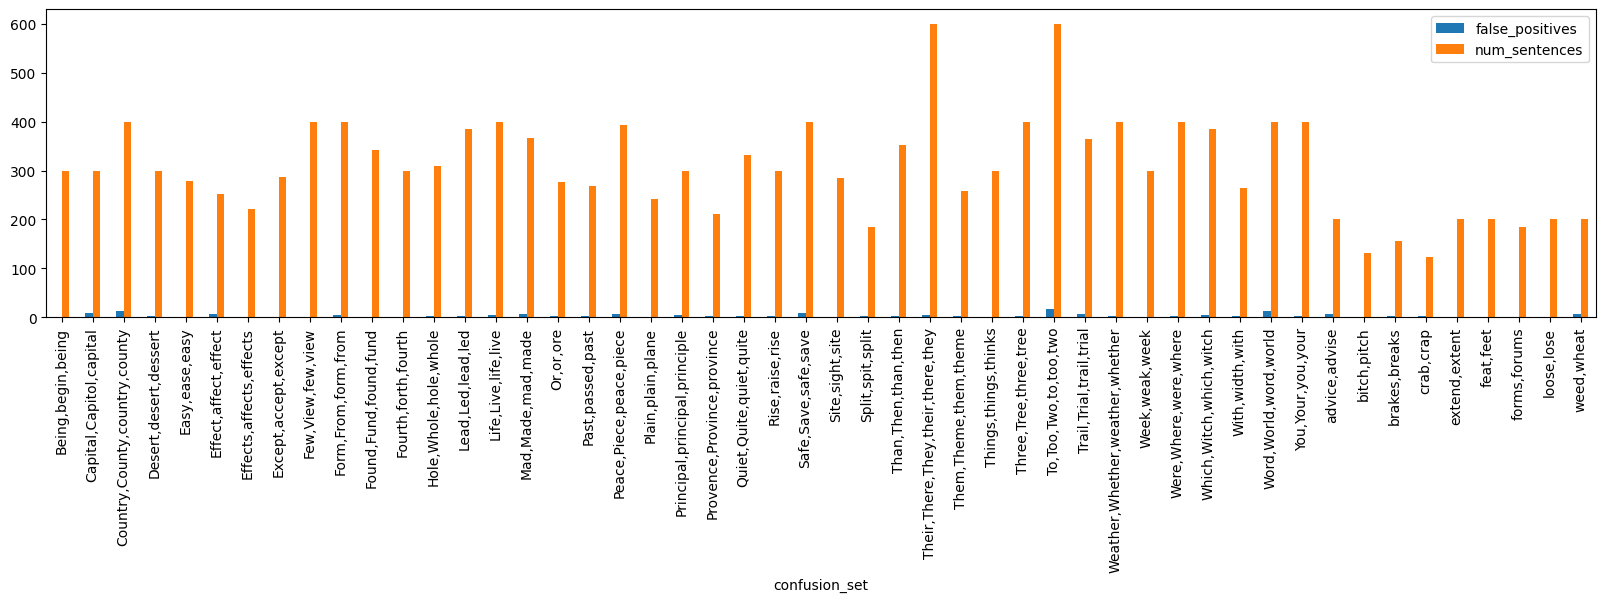

In [6]:
tp_df = pd.read_csv(file_name, sep=';')
tp_df.columns = ['confusion_set', 'false_positives', 'num_sentences']
tp_df.index = tp_df['confusion_set']
tp_df.plot(kind="bar", figsize=(20,4))

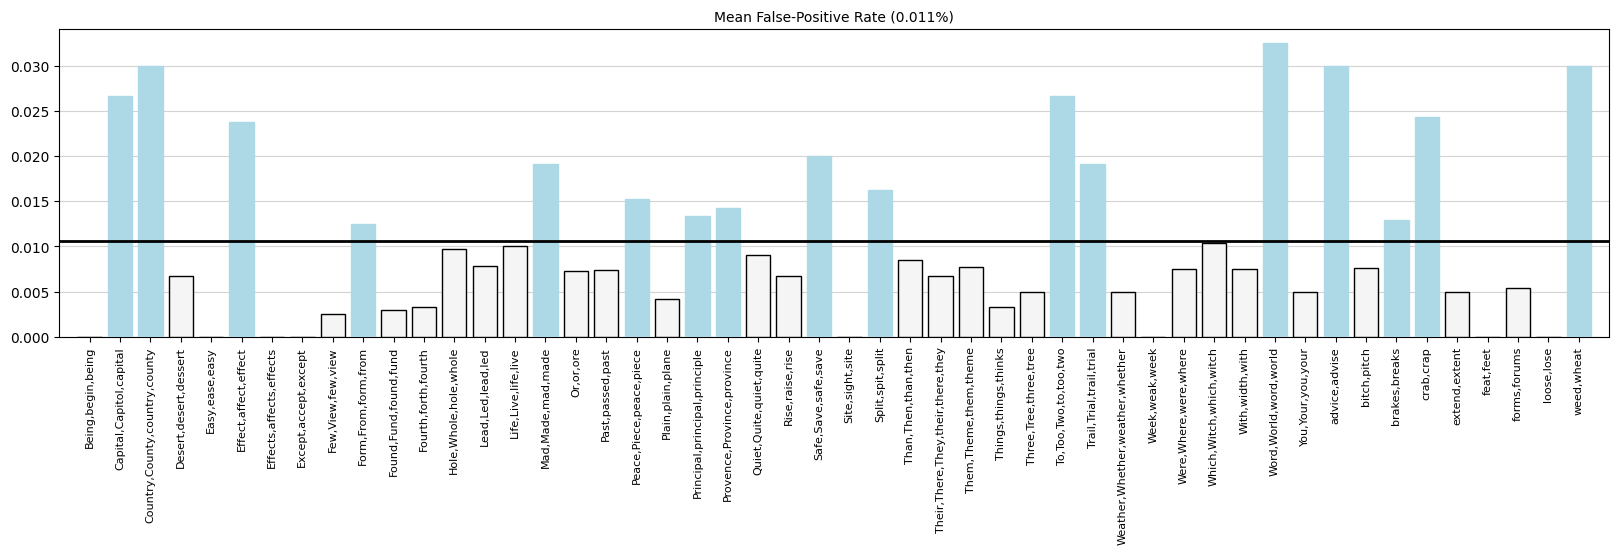

In [7]:
xticks = list(range(len(data_mean_fpr)))
values = list(data_mean_fpr.values())
labels = list(data_mean_fpr.keys())

fig, ax = plt.subplots(figsize=(20,4))
ax.set_title(f"Mean False-Positive Rate ({mean_fpr:.3f}%)", fontsize=10)
bars = ax.bar(xticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value > mean_fpr:
        bars[idx].set_color('lightblue')
ax.set_xticks(xticks, labels, rotation='vertical')
ax.xaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)
ax.margins(x=0) # removes white space surrounding bars

x = np.linspace(-1, len(data_mean_fpr))
y = [mean_fpr]*len(x)
ax.plot(x, y, zorder=3, color="black", linewidth=2)

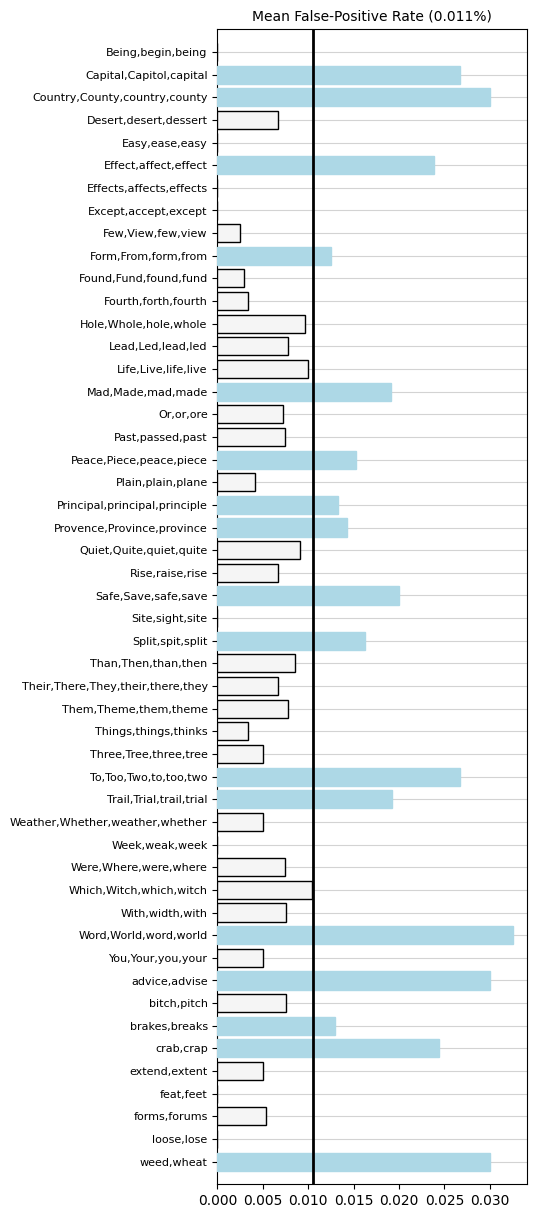

In [8]:
yticks = list(range(len(data_mean_fpr)))
values = list(data_mean_fpr.values())
labels = list(data_mean_fpr.keys())

values.reverse()
labels.reverse()

fig, ax = plt.subplots(figsize=(4,15))
ax.set_title(f"Mean False-Positive Rate ({mean_fpr:.3f}%)", fontsize=10)
bars = ax.barh(yticks, values, zorder=3, color="whitesmoke", edgecolor="black", linewidth=1, align="center")
for idx, value in enumerate(values):
    if value > mean_fpr:
        bars[idx].set_color('lightblue')
ax.set_yticks(yticks, labels, rotation='horizontal')
ax.yaxis.set_tick_params(labelsize=8)
ax.grid(color='lightgray', axis="y", zorder=0)
ax.margins(y=0)

x = [mean_fpr]*len(x)
y = np.linspace(-1, len(data_mean_fpr))
ax.plot(x, y, zorder=3, color="black", linewidth=2)